In [379]:
# @title Load Packages
%pip install sqldf
%pip install statsmodels
import sqldf
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
from google.cloud import bigquery
import random as r
import warnings
import matplotlib.pyplot as plt
import datetime, pytz
import os
import math
import time
from datetime import date, datetime, timedelta
from tqdm import tqdm
from scipy.stats import norm, binom
import seaborn as sns
from statsmodels.stats import proportion as prop
from matplotlib.ticker import FuncFormatter
import shutil

warnings.filterwarnings('ignore')

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [380]:
#@title Code to Refresh Directory
delete_directory_path = '/content/Experiment Analysis Outputs: HP Anchor Hero CTA to Plan Picker' # @param {type:"string"}
if os.path.exists(delete_directory_path):
    shutil.rmtree(delete_directory_path)  # This deletes a folder and its contents recursively
    print(f"Deleted {delete_directory_path}")
else:
    print(f"The folder '{delete_directory_path}' does not exist.")

Deleted /content/Experiment Analysis Outputs: HP Anchor Hero CTA to Plan Picker


In [381]:
# @title Experiment Parameters { run: "auto", vertical-output: true, form-width: "50%", display-mode: "both" }
id_type = "visitor id" # @param ["visitor id", "tracking id"]
experiment_id = 25003380671 # @param {type:"string"}
significance_level = .1 # @param {type:"number"}
experiment_start_date = '2023-08-09' # @param{type:"date"}
experiment_end_date = '2023-08-29'# @param{type:"date"}

url_1_metric_name = 'Visits' #@param {type:"string"}
url_2_metric_name = 'Clicks' #@param {type:"string"}
url_3_metric_name = 'Conversions' #@param {type:"string"}
url_4_metric_name = 'None' #@param {type:"string"}

bq_config_vars = {'project_id': 'nbcu-ds-sandbox-a-001',
                  'dataset_id': 'nbcu-ds-prod-001'}

which_url_determines_conversion = 3 # @param [3, 4]
which_url_determines_denominator = 1 # @param [1, 2,3]
control_name = 'Control' #@param {type:"string"}

url_metric_name_list = [url_1_metric_name,
            url_2_metric_name,
            url_3_metric_name,
            url_4_metric_name
]


denom_name = url_metric_name_list[which_url_determines_denominator - 1]
print(denom_name)

Visits


In [382]:
# @title Query Dolphin
def get_experiment_data(id_type):

  if id_type == "visitor id":
    id = 'visitor_id'
    table = '`nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_commerce_web_test_visitor_level`'
  elif id_type == "tracking id":
    id = 'tracking_id'
    table = '`nbcu-ds-prod-001.PeacockDataMartProductAnalyticsSilver.silver_commerce_web_test_tracking_id_level`'
  else:
    print("Invalid user type parameter given. Reconfigure Experiment Parameters please.")
    pass

  query = f"""
    SELECT
    {id} AS id,
    min_date AS exposure_date,
    test_name,
    variant_name,
    status,
    visitor_entitlement,
    billing_cycle,
    user_status,
    been_to_url1,
    been_to_url2,
    been_to_url3,
    been_to_url4
    FROM
    {table}
    WHERE 1=1
    AND test_id = '{experiment_id}'
    AND min_date BETWEEN '{experiment_start_date}' AND '{experiment_end_date}'
  """

  df  = pd.read_gbq(query,project_id = bq_config_vars['project_id'], use_bqstorage_api=True, progress_bar_type = 'tqdm')

  experiment_name = df['test_name'].unique().astype('str')[0]
  """
  # Specify the file path where you want to save the text file
  file_path = f"query.txt"  # You can change the file name and path as needed
  # Open the file in write mode and write the string to it
  with open(file_path, "w") as text_file:
      text_file.write(query)
  # Confirm that the file has been saved
  print(f"BQ Query has been saved to '{file_path}'.")
  """
  return(df, experiment_name,query)

results = get_experiment_data(id_type)
query_df, experiment_name, query = results[0], results[1], results[2]



Downloading: 100%|██████████|


In [383]:
#@title Set up Output Directory
# Create subfolders
al_name, htv_name, tsv_name = "Analysis Log", "Hypothesis Test Visuals", "Time Series Visuals"
parent_folder = "Experiment Analysis Outputs: " + experiment_name
# Create the parent folder if it doesn't exist
if not os.path.exists(parent_folder):
    os.mkdir(parent_folder)
  # Change the working directory to the parent folder
os.chdir(parent_folder)
# Create the subfolders if they don't exist
for subfolder in [al_name, htv_name, tsv_name]:
    if not os.path.exists(subfolder):
        os.mkdir(subfolder)

# Switch working directory back to the parent folder
os.chdir("..")  # Use ".." to navigate up one level
# Verify the current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /content


In [384]:
# @title Parse out Conversions
def parse_conversions(df):
  """
  update been_to_url columns to incorporate "AND" conditioning/ account for data spillovers
  """
  url4_condition = ((df['been_to_url1'] == 1) & (df['been_to_url2'] == 1) & (df['been_to_url3'] == 1) & (df['been_to_url4'] == 1))
  url3_condition = (url4_condition | ((df['been_to_url1'] == 1) & (df['been_to_url2'] == 1) & (df['been_to_url3'] == 1) & (df['been_to_url4'] == 0)))
  url2_condition = (url3_condition | ((df['been_to_url1'] == 1) & (df['been_to_url2'] == 1) & (df['been_to_url3'] == 0) & (df['been_to_url4'] == 0)))
  url1_condition = (url2_condition | ((df['been_to_url1'] == 1) & (df['been_to_url2'] == 0) & (df['been_to_url3'] == 0) & (df['been_to_url4'] == 0)))

  df[url_1_metric_name] = url1_condition
  df[url_2_metric_name] = url2_condition
  df[url_3_metric_name] = url3_condition
  df[url_4_metric_name] = url4_condition

  conversion_cols = [df[url_1_metric_name], df[url_2_metric_name], df[url_3_metric_name], df[url_4_metric_name]]
  for i, v in enumerate(conversion_cols):
    if i+1 == which_url_determines_conversion:
      conversion_col = v

  df['Monthly Conversions'] = (conversion_col) & (df['billing_cycle'] == 'MONTHLY')
  df['Annual Conversions'] = (conversion_col) & (df['billing_cycle'] == 'ANNUAL')
  df['Premium Conversions'] = (conversion_col) & (df['visitor_entitlement'] == 'Premium')
  df['Premium Plus Conversions'] = (conversion_col) & (df['visitor_entitlement'] == 'Premium+')

  df['Premium Monthly Conversions'] = df['Premium Conversions'] & (df['billing_cycle'] == 'MONTHLY')
  df['Premium Monthly Plus Conversions'] = df['Premium Plus Conversions'] & (df['billing_cycle'] == 'MONTHLY')
  df['Premium Annual Conversions'] = df['Premium Conversions'] & (df['billing_cycle'] == 'ANNUAL')
  df['Premium Plus Annual Conversions'] = df['Premium Plus Conversions'] & (df['billing_cycle'] == 'ANNUAL')
  return(df)

conversion_df = parse_conversions(query_df)
display(conversion_df.head(20))
display(conversion_df.describe())
display(conversion_df.info())

,id,exposure_date,test_name,variant_name,status,visitor_entitlement,billing_cycle,user_status,been_to_url1,been_to_url2,...,Conversions,None,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
0,30965286974291521401554552013789397012,2023-08-15,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False
1,34666090078069233497199281605379549929,2023-08-16,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False
2,19735403128109474775237342717383194831,2023-08-19,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False
3,1490323414751184427696466171042212831,2023-08-13,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False
4,52092653742396793853633605965109863208,2023-08-18,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False
5,392860131050265078294615010675005947,2023-08-23,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False
6,33583220210335216353641358637324984192,2023-08-17,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False
7,34691532144474264146827823980225760716,2023-08-10,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False
8,77108186379661913775805393451973644913,2023-08-15,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False
9,37393927333430066004079430522713082516,2023-08-18,HP Anchor Hero CTA to Plan Picker,Control,Completed,None,None,new acquisition,1,0,...,False,False,False,False,False,False,False,False,False,False


,been_to_url1,been_to_url2,been_to_url3,been_to_url4
count,444173.0,444173.0,444173.0,444173.0
mean,1.0,0.085161,0.048558,0.0
std,0.0,0.279121,0.214942,0.0
min,1.0,0.0,0.0,0.0
25%,1.0,0.0,0.0,0.0
50%,1.0,0.0,0.0,0.0
75%,1.0,0.0,0.0,0.0
max,1.0,1.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444173 entries, 0 to 444172
Data columns (total 24 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                444173 non-null  object 
 1   exposure_date                     444173 non-null  dbdate 
 2   test_name                         444173 non-null  object 
 3   variant_name                      444173 non-null  object 
 4   status                            444173 non-null  object 
 5   visitor_entitlement               163184 non-null  object 
 6   billing_cycle                     163184 non-null  object 
 7   user_status                       444173 non-null  object 
 8   been_to_url1                      444173 non-null  Int64  
 9   been_to_url2                      444173 non-null  Int64  
 10  been_to_url3                      444173 non-null  Int64  
 11  been_to_url4                      444173 non-null  I

None

In [385]:
# @title Aggregate Counts
def aggregate_counts(df):
  """
  Returns: dictionary of dataframes with sum/cumsum of raw, granular conversions (defined in 'value_list')
  """
  #value list will be all booleans from above
  value_list = df.select_dtypes(include='bool').columns.tolist()
  try:
    value_list.remove('None')
    print(value_list)
  except:
    print("No booleans for value list found")
  try:
    date_col = df.select_dtypes(include = 'dbdate').columns.tolist()[0]
  except:
    print("No Date column Found Error!")

  try: #agg to grain level
    grain_level_df = df.groupby([date_col, "variant_name", "user_status"])[value_list].agg('sum')
    # get cumulative daily sum by grain
    cum_daily_grain_level_df = grain_level_df.sort_values(["variant_name", "user_status",date_col]).groupby(['variant_name', 'user_status']).cumsum()
  except:
    grain_level_df = pd.DataFrame()
    cum_daily_grain_level_df = pd.DataFrame()
    print("daily grain level aggregation failed")

  try: # agg to variant level
    daily_variant_level_df = df.groupby([date_col, 'variant_name'])[value_list].agg('sum')
    # get cumulative daily sum by variant
    cum_daily_variant_level_df = daily_variant_level_df.sort_values(["variant_name", date_col]).groupby('variant_name').cumsum()
  except:
    daily_variant_level_df = pd.DataFrame()
    cum_daily_variant_level_df = pd.DataFrame()
    print('daily variant level agg failed')

  try:  #agg to overalls
    overall_grain_level_df = df.groupby(['variant_name', 'user_status'])[value_list].agg('sum')
    # #aggregate to overall by variant
    overall_variant_level_df = df.groupby(['variant_name'])[value_list].agg('sum')
  except:
    overall_grain_level_df = pd.DataFrame()
    overall_variant_level_df = pd.DataFrame()
    print('overall level agg failed')

  #place dataframes into a dictionary to return
  analysis_data_dict = {
      'Daily Variant-User Status Level' : grain_level_df.reset_index(),
      'Daily Variant Level': daily_variant_level_df.reset_index(),
      'Cumulative Daily Variant-User Status Level': cum_daily_grain_level_df.reset_index(),
      'Cumulative Daily Variant Level': cum_daily_variant_level_df.reset_index(),
      'Overall Variant-User Status Level': overall_grain_level_df.reset_index(),
      'Overall Variant Level': overall_variant_level_df.reset_index()
  }
  return(analysis_data_dict)

#instantiate dictionary of aggregated data
agg_dfs_dict = aggregate_counts(conversion_df)
for i,v in agg_dfs_dict.items():
  display(f"Info on {i}")
  display(v.head())
  display(v.describe())
  display(v.info())

['Visits', 'Clicks', 'Conversions', 'Monthly Conversions', 'Annual Conversions', 'Premium Conversions', 'Premium Plus Conversions', 'Premium Monthly Conversions', 'Premium Monthly Plus Conversions', 'Premium Annual Conversions', 'Premium Plus Annual Conversions']


'Info on Daily Variant-User Status Level'

,exposure_date,variant_name,user_status,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
0,2023-08-09,Control,existing,2109,201,120,115,5,84,35,82,32,2,3
1,2023-08-09,Control,new acquisition,4659,358,148,143,5,105,43,102,41,3,2
2,2023-08-09,Treatment,existing,2246,240,139,133,6,97,42,92,41,5,1
3,2023-08-09,Treatment,new acquisition,4860,354,158,148,10,104,54,97,51,7,3
4,2023-08-10,Control,existing,4163,357,209,191,18,162,47,149,42,13,5


,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
count,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
mean,6489.014706,556.264706,274.235294,257.161765,17.0,204.117647,69.602941,192.441176,64.279412,11.676471,5.323529
std,2669.162821,269.023586,137.151416,125.93289,12.647931,112.613926,26.898449,104.314018,23.80571,10.100157,3.662807
min,2109.0,201.0,120.0,115.0,2.0,84.0,34.0,82.0,31.0,1.0,0.0
25%,4158.25,343.5,175.0,168.0,9.0,123.0,49.0,118.75,46.75,5.0,3.0
50%,5976.5,512.0,221.0,207.0,13.0,156.5,64.5,149.5,60.0,8.5,5.0
75%,8524.25,656.5,324.0,309.25,21.25,253.25,82.25,242.25,77.0,14.0,7.0
max,12470.0,1331.0,658.0,607.0,56.0,503.0,152.0,472.0,133.0,43.0,19.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   exposure_date                     68 non-null     dbdate
 1   variant_name                      68 non-null     object
 2   user_status                       68 non-null     object
 3   Visits                            68 non-null     Int64 
 4   Clicks                            68 non-null     Int64 
 5   Conversions                       68 non-null     Int64 
 6   Monthly Conversions               68 non-null     Int64 
 7   Annual Conversions                68 non-null     Int64 
 8   Premium Conversions               68 non-null     Int64 
 9   Premium Plus Conversions          68 non-null     Int64 
 10  Premium Monthly Conversions       68 non-null     Int64 
 11  Premium Monthly Plus Conversions  68 non-null     Int64 
 12  Premium Annual Conversio

None

'Info on Daily Variant Level'

,exposure_date,variant_name,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
0,2023-08-09,Control,6768,559,268,258,10,189,78,184,73,5,5
1,2023-08-09,Treatment,7106,594,297,281,16,201,96,189,92,12,4
2,2023-08-10,Control,12993,991,463,426,37,353,109,329,96,24,13
3,2023-08-10,Treatment,13027,1009,497,448,47,353,142,319,129,34,13
4,2023-08-11,Control,14526,1334,679,622,56,508,170,466,156,42,14


,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
count,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0
mean,12978.029412,1112.529412,548.470588,514.323529,34.0,408.235294,139.205882,384.882353,128.558824,23.352941,10.647059
std,2758.535464,434.493243,271.04626,248.213706,24.875447,224.511734,48.168756,207.575582,42.376517,19.480966,6.50353
min,6768.0,559.0,268.0,258.0,10.0,189.0,78.0,184.0,73.0,4.0,3.0
25%,11431.25,793.0,351.25,331.5,16.25,239.0,104.25,226.5,98.75,10.0,6.0
50%,12742.5,942.0,447.5,420.0,27.0,310.5,123.5,297.0,115.0,17.0,9.0
75%,14628.0,1338.5,682.0,625.75,38.5,507.0,170.75,470.5,159.0,27.25,13.75
max,18470.0,2171.0,1255.0,1161.0,104.0,981.0,268.0,920.0,236.0,78.0,32.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   exposure_date                     34 non-null     dbdate
 1   variant_name                      34 non-null     object
 2   Visits                            34 non-null     Int64 
 3   Clicks                            34 non-null     Int64 
 4   Conversions                       34 non-null     Int64 
 5   Monthly Conversions               34 non-null     Int64 
 6   Annual Conversions                34 non-null     Int64 
 7   Premium Conversions               34 non-null     Int64 
 8   Premium Plus Conversions          34 non-null     Int64 
 9   Premium Monthly Conversions       34 non-null     Int64 
 10  Premium Monthly Plus Conversions  34 non-null     Int64 
 11  Premium Annual Conversions        34 non-null     Int64 
 12  Premium Plus Annual Conv

None

'Info on Cumulative Daily Variant-User Status Level'

,exposure_date,variant_name,user_status,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
0,2023-08-09,Control,existing,2109,201,120,115,5,84,35,82,32,2,3
1,2023-08-10,Control,existing,6272,558,329,306,23,246,82,231,74,15,8
2,2023-08-11,Control,existing,11137,1060,651,596,55,497,153,458,137,39,16
3,2023-08-12,Control,existing,17046,1810,1180,1078,102,933,246,853,224,80,22
4,2023-08-13,Control,existing,22999,2606,1726,1581,145,1389,336,1270,310,119,26


,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
count,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
mean,59681.926471,5238.573529,2631.632353,2451.161765,179.485294,1963.470588,662.470588,1836.926471,609.529412,126.544118,52.941176
std,40814.762445,3240.318044,1404.601892,1320.48723,87.338677,1033.6733,376.589268,977.594921,346.535108,61.815912,30.822497
min,2109.0,201.0,120.0,115.0,5.0,84.0,35.0,82.0,32.0,2.0,1.0
25%,27690.75,2951.75,1834.75,1677.0,139.0,1434.75,386.0,1318.0,355.25,95.0,30.0
50%,54583.5,5046.0,2633.0,2435.0,191.5,1987.5,669.0,1823.0,616.0,138.5,52.5
75%,82610.5,6769.25,3811.5,3561.25,244.25,2859.5,934.5,2684.0,860.75,172.75,76.0
max,148605.0,12076.0,5172.0,4854.0,314.0,3682.0,1476.0,3494.0,1350.0,228.0,126.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   exposure_date                     68 non-null     dbdate
 1   variant_name                      68 non-null     object
 2   user_status                       68 non-null     object
 3   Visits                            68 non-null     Int64 
 4   Clicks                            68 non-null     Int64 
 5   Conversions                       68 non-null     Int64 
 6   Monthly Conversions               68 non-null     Int64 
 7   Annual Conversions                68 non-null     Int64 
 8   Premium Conversions               68 non-null     Int64 
 9   Premium Plus Conversions          68 non-null     Int64 
 10  Premium Monthly Conversions       68 non-null     Int64 
 11  Premium Monthly Plus Conversions  68 non-null     Int64 
 12  Premium Annual Conversio

None

'Info on Cumulative Daily Variant Level'

,exposure_date,variant_name,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
0,2023-08-09,Control,6768,559,268,258,10,189,78,184,73,5,5
1,2023-08-10,Control,19761,1550,731,684,47,542,187,513,169,29,18
2,2023-08-11,Control,34287,2884,1410,1306,103,1050,357,979,325,71,32
3,2023-08-12,Control,52244,4785,2470,2283,186,1895,572,1760,521,135,51
4,2023-08-13,Control,70563,6893,3648,3372,275,2852,791,2645,723,207,68


,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
count,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0
mean,119363.852941,10477.147059,5263.264706,4902.323529,358.970588,3926.941176,1324.941176,3673.852941,1219.058824,253.088235,105.882353
std,66411.254196,5687.787433,2797.845506,2624.785379,175.446355,2072.908861,724.29422,1955.721182,668.058605,119.414828,57.547222
min,6768.0,559.0,268.0,258.0,10.0,189.0,78.0,184.0,73.0,5.0,4.0
25%,70754.25,6942.0,3699.0,3412.25,281.75,2866.25,822.0,2654.25,751.75,211.5,70.25
50%,121310.0,10511.5,5296.0,4910.0,380.0,3956.5,1336.5,3681.0,1231.0,274.5,106.5
75%,175675.0,15527.25,7709.75,7236.0,488.25,5781.75,1950.75,5423.25,1788.75,344.5,145.75
max,221526.0,19191.0,9614.0,8984.0,626.0,7053.0,2539.0,6637.0,2329.0,416.0,210.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   exposure_date                     34 non-null     dbdate
 1   variant_name                      34 non-null     object
 2   Visits                            34 non-null     Int64 
 3   Clicks                            34 non-null     Int64 
 4   Conversions                       34 non-null     Int64 
 5   Monthly Conversions               34 non-null     Int64 
 6   Annual Conversions                34 non-null     Int64 
 7   Premium Conversions               34 non-null     Int64 
 8   Premium Plus Conversions          34 non-null     Int64 
 9   Premium Monthly Conversions       34 non-null     Int64 
 10  Premium Monthly Plus Conversions  34 non-null     Int64 
 11  Premium Annual Conversions        34 non-null     Int64 
 12  Premium Plus Annual Conv

None

'Info on Overall Variant-User Status Level'

,variant_name,user_status,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
0,Control,existing,72512,6654,4196,3924,272,3236,957,3026,895,210,62
1,Control,new acquisition,147215,11981,4838,4579,258,3591,1237,3423,1147,168,90
2,Treatment,existing,72921,7115,4442,4130,312,3371,1063,3143,979,228,84
3,Treatment,new acquisition,148605,12076,5172,4854,314,3682,1476,3494,1350,188,126


,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
count,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
mean,110313.25,9456.5,4662.0,4371.75,289.0,3470.0,1183.25,3271.5,1092.75,198.5,90.5
std,43417.017143,2976.099741,430.748186,422.074539,28.307832,203.422385,226.745636,223.040355,200.968281,26.095977,26.551836
min,72512.0,6654.0,4196.0,3924.0,258.0,3236.0,957.0,3026.0,895.0,168.0,62.0
25%,72818.75,6999.75,4380.5,4078.5,268.5,3337.25,1036.5,3113.75,958.0,183.0,78.5
50%,110068.0,9548.0,4640.0,4354.5,292.0,3481.0,1150.0,3283.0,1063.0,199.0,87.0
75%,147562.5,12004.75,4921.5,4647.75,312.5,3613.75,1296.75,3440.75,1197.75,214.5,99.0
max,148605.0,12076.0,5172.0,4854.0,314.0,3682.0,1476.0,3494.0,1350.0,228.0,126.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   variant_name                      4 non-null      object
 1   user_status                       4 non-null      object
 2   Visits                            4 non-null      Int64 
 3   Clicks                            4 non-null      Int64 
 4   Conversions                       4 non-null      Int64 
 5   Monthly Conversions               4 non-null      Int64 
 6   Annual Conversions                4 non-null      Int64 
 7   Premium Conversions               4 non-null      Int64 
 8   Premium Plus Conversions          4 non-null      Int64 
 9   Premium Monthly Conversions       4 non-null      Int64 
 10  Premium Monthly Plus Conversions  4 non-null      Int64 
 11  Premium Annual Conversions        4 non-null      Int64 
 12  Premium Plus Annual Conver

None

'Info on Overall Variant Level'

,variant_name,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
0,Control,219727,18635,9034,8503,530,6827,2194,6449,2042,378,152
1,Treatment,221526,19191,9614,8984,626,7053,2539,6637,2329,416,210


,Visits,Clicks,Conversions,Monthly Conversions,Annual Conversions,Premium Conversions,Premium Plus Conversions,Premium Monthly Conversions,Premium Monthly Plus Conversions,Premium Annual Conversions,Premium Plus Annual Conversions
count,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
mean,220626.5,18913.0,9324.0,8743.5,578.0,6940.0,2366.5,6543.0,2185.5,397.0,181.0
std,1272.085099,393.15137,410.121933,340.118362,67.882251,159.806133,243.95184,132.936075,202.939646,26.870058,41.012193
min,219727.0,18635.0,9034.0,8503.0,530.0,6827.0,2194.0,6449.0,2042.0,378.0,152.0
25%,220176.75,18774.0,9179.0,8623.25,554.0,6883.5,2280.25,6496.0,2113.75,387.5,166.5
50%,220626.5,18913.0,9324.0,8743.5,578.0,6940.0,2366.5,6543.0,2185.5,397.0,181.0
75%,221076.25,19052.0,9469.0,8863.75,602.0,6996.5,2452.75,6590.0,2257.25,406.5,195.5
max,221526.0,19191.0,9614.0,8984.0,626.0,7053.0,2539.0,6637.0,2329.0,416.0,210.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   variant_name                      2 non-null      object
 1   Visits                            2 non-null      Int64 
 2   Clicks                            2 non-null      Int64 
 3   Conversions                       2 non-null      Int64 
 4   Monthly Conversions               2 non-null      Int64 
 5   Annual Conversions                2 non-null      Int64 
 6   Premium Conversions               2 non-null      Int64 
 7   Premium Plus Conversions          2 non-null      Int64 
 8   Premium Monthly Conversions       2 non-null      Int64 
 9   Premium Monthly Plus Conversions  2 non-null      Int64 
 10  Premium Annual Conversions        2 non-null      Int64 
 11  Premium Plus Annual Conversions   2 non-null      Int64 
dtypes: Int64(11), object(1)
me

None

In [386]:
#@title Compute Conversion Rate
def compute_conversions(dict):
  """ Arg: a dictionary of dataframes
  Returns: updated dictionary of dataframes with conversion metrics as new columns for each dataframe
  """
  dict_copy = dict.copy()
  for key, val in enumerate(dict_copy):
    #grab a data frame
    df = dict_copy[val]
    #get numeric numerator columns, exclude denominator column
    num_cols = df.select_dtypes(include = 'int64').columns.tolist()
    num_cols.remove(denom_name) # dont need conversion on denominator
    #compute conversion rate for each numerator/denominator
    for i in num_cols:
      if i.endswith("s") or i.endswith("es"):
        new_i = i[:-1]
        print(new_i)
      else:
        new_i = i
      new_col = new_i+" Rate"
      df[new_col] = df[i]/df[denom_name]
    #update dictionary
    updates = {val: df}
    dict_copy.update(updates)
  return(dict_copy)
#create conversion dict
agg_conversions_dict = compute_conversions(agg_dfs_dict)
#display(agg_conversions_dict)

for i,v in agg_conversions_dict.items():
  print(i)
  print(v.dtypes)
  print('\n')
  print("Describing: ",i,  v.head())


Click
Conversion
Monthly Conversion
Annual Conversion
Premium Conversion
Premium Plus Conversion
Premium Monthly Conversion
Premium Monthly Plus Conversion
Premium Annual Conversion
Premium Plus Annual Conversion
Click
Conversion
Monthly Conversion
Annual Conversion
Premium Conversion
Premium Plus Conversion
Premium Monthly Conversion
Premium Monthly Plus Conversion
Premium Annual Conversion
Premium Plus Annual Conversion
Click
Conversion
Monthly Conversion
Annual Conversion
Premium Conversion
Premium Plus Conversion
Premium Monthly Conversion
Premium Monthly Plus Conversion
Premium Annual Conversion
Premium Plus Annual Conversion
Click
Conversion
Monthly Conversion
Annual Conversion
Premium Conversion
Premium Plus Conversion
Premium Monthly Conversion
Premium Monthly Plus Conversion
Premium Annual Conversion
Premium Plus Annual Conversion
Click
Conversion
Monthly Conversion
Annual Conversion
Premium Conversion
Premium Plus Conversion
Premium Monthly Conversion
Premium Monthly Plus Con

In [387]:
# @title Compute Relative Lifts
def compute_relative_lift(dict):
  dict_copy = dict.copy()
  for key, val in enumerate(dict_copy):
    df = dict_copy[val]
    control_df = df[df['variant_name'] == control_name]
    join_keys = df.select_dtypes(exclude=np.number).columns.tolist()
    join_keys.remove('variant_name')
    #get rate columns
    rate_cols =  [col for col in df.columns if np.logical_or('Rate' in col, col== denom_name)]
    control_suffix = '_control_val'
    #merge in corresponding control value based on join keys
    if len(join_keys) > 0:
      df_with_control = df.merge(control_df, on = join_keys, how = 'left', suffixes = ('', control_suffix))
    else:
      df['key'] =1
      control_df['key'] = 1
      df_with_control = df.merge(control_df, on = 'key', how = 'left', suffixes = ('', control_suffix))
      df_with_control.drop(columns = 'key', inplace = True)
    # print(df_with_control.columns)
    for i in rate_cols:
      new_col = i+" Relative Lift vs Control"
      # add new column which is current value/ control value
      df_with_control[new_col] = df_with_control[i]/df_with_control[i+control_suffix] - 1.0
    # parse joined control values after calculation
    columns_to_drop = [col for col in df_with_control.columns if control_suffix in col]
    # Drop the columns containing control suffix, no longer needed
    df_with_control.drop(columns=columns_to_drop, inplace=True)
    #update dictionary
    updates = {val: df_with_control}
    dict_copy.update(updates)
  return(dict_copy)
#add relative lifts to dictionary
agg_lifts_dict = compute_relative_lift(agg_conversions_dict)
for i,v in agg_lifts_dict.items():
  display(i, v.columns)

'Daily Variant-User Status Level'

Index(['exposure_date', 'variant_name', 'user_status', 'Visits', 'Clicks',
       'Conversions', 'Monthly Conversions', 'Annual Conversions',
       'Premium Conversions', 'Premium Plus Conversions',
       'Premium Monthly Conversions', 'Premium Monthly Plus Conversions',
       'Premium Annual Conversions', 'Premium Plus Annual Conversions',
       'Click Rate', 'Conversion Rate', 'Monthly Conversion Rate',
       'Annual Conversion Rate', 'Premium Conversion Rate',
       'Premium Plus Conversion Rate', 'Premium Monthly Conversion Rate',
       'Premium Monthly Plus Conversion Rate',
       'Premium Annual Conversion Rate', 'Premium Plus Annual Conversion Rate',
       'Visits Relative Lift vs Control',
       'Click Rate Relative Lift vs Control',
       'Conversion Rate Relative Lift vs Control',
       'Monthly Conversion Rate Relative Lift vs Control',
       'Annual Conversion Rate Relative Lift vs Control',
       'Premium Conversion Rate Relative Lift vs Control',
       'Pre

'Daily Variant Level'

Index(['exposure_date', 'variant_name', 'Visits', 'Clicks', 'Conversions',
       'Monthly Conversions', 'Annual Conversions', 'Premium Conversions',
       'Premium Plus Conversions', 'Premium Monthly Conversions',
       'Premium Monthly Plus Conversions', 'Premium Annual Conversions',
       'Premium Plus Annual Conversions', 'Click Rate', 'Conversion Rate',
       'Monthly Conversion Rate', 'Annual Conversion Rate',
       'Premium Conversion Rate', 'Premium Plus Conversion Rate',
       'Premium Monthly Conversion Rate',
       'Premium Monthly Plus Conversion Rate',
       'Premium Annual Conversion Rate', 'Premium Plus Annual Conversion Rate',
       'Visits Relative Lift vs Control',
       'Click Rate Relative Lift vs Control',
       'Conversion Rate Relative Lift vs Control',
       'Monthly Conversion Rate Relative Lift vs Control',
       'Annual Conversion Rate Relative Lift vs Control',
       'Premium Conversion Rate Relative Lift vs Control',
       'Premium Plus Conve

'Cumulative Daily Variant-User Status Level'

Index(['exposure_date', 'variant_name', 'user_status', 'Visits', 'Clicks',
       'Conversions', 'Monthly Conversions', 'Annual Conversions',
       'Premium Conversions', 'Premium Plus Conversions',
       'Premium Monthly Conversions', 'Premium Monthly Plus Conversions',
       'Premium Annual Conversions', 'Premium Plus Annual Conversions',
       'Click Rate', 'Conversion Rate', 'Monthly Conversion Rate',
       'Annual Conversion Rate', 'Premium Conversion Rate',
       'Premium Plus Conversion Rate', 'Premium Monthly Conversion Rate',
       'Premium Monthly Plus Conversion Rate',
       'Premium Annual Conversion Rate', 'Premium Plus Annual Conversion Rate',
       'Visits Relative Lift vs Control',
       'Click Rate Relative Lift vs Control',
       'Conversion Rate Relative Lift vs Control',
       'Monthly Conversion Rate Relative Lift vs Control',
       'Annual Conversion Rate Relative Lift vs Control',
       'Premium Conversion Rate Relative Lift vs Control',
       'Pre

'Cumulative Daily Variant Level'

Index(['exposure_date', 'variant_name', 'Visits', 'Clicks', 'Conversions',
       'Monthly Conversions', 'Annual Conversions', 'Premium Conversions',
       'Premium Plus Conversions', 'Premium Monthly Conversions',
       'Premium Monthly Plus Conversions', 'Premium Annual Conversions',
       'Premium Plus Annual Conversions', 'Click Rate', 'Conversion Rate',
       'Monthly Conversion Rate', 'Annual Conversion Rate',
       'Premium Conversion Rate', 'Premium Plus Conversion Rate',
       'Premium Monthly Conversion Rate',
       'Premium Monthly Plus Conversion Rate',
       'Premium Annual Conversion Rate', 'Premium Plus Annual Conversion Rate',
       'Visits Relative Lift vs Control',
       'Click Rate Relative Lift vs Control',
       'Conversion Rate Relative Lift vs Control',
       'Monthly Conversion Rate Relative Lift vs Control',
       'Annual Conversion Rate Relative Lift vs Control',
       'Premium Conversion Rate Relative Lift vs Control',
       'Premium Plus Conve

'Overall Variant-User Status Level'

Index(['variant_name', 'user_status', 'Visits', 'Clicks', 'Conversions',
       'Monthly Conversions', 'Annual Conversions', 'Premium Conversions',
       'Premium Plus Conversions', 'Premium Monthly Conversions',
       'Premium Monthly Plus Conversions', 'Premium Annual Conversions',
       'Premium Plus Annual Conversions', 'Click Rate', 'Conversion Rate',
       'Monthly Conversion Rate', 'Annual Conversion Rate',
       'Premium Conversion Rate', 'Premium Plus Conversion Rate',
       'Premium Monthly Conversion Rate',
       'Premium Monthly Plus Conversion Rate',
       'Premium Annual Conversion Rate', 'Premium Plus Annual Conversion Rate',
       'Visits Relative Lift vs Control',
       'Click Rate Relative Lift vs Control',
       'Conversion Rate Relative Lift vs Control',
       'Monthly Conversion Rate Relative Lift vs Control',
       'Annual Conversion Rate Relative Lift vs Control',
       'Premium Conversion Rate Relative Lift vs Control',
       'Premium Plus Convers

'Overall Variant Level'

Index(['variant_name', 'Visits', 'Clicks', 'Conversions',
       'Monthly Conversions', 'Annual Conversions', 'Premium Conversions',
       'Premium Plus Conversions', 'Premium Monthly Conversions',
       'Premium Monthly Plus Conversions', 'Premium Annual Conversions',
       'Premium Plus Annual Conversions', 'Click Rate', 'Conversion Rate',
       'Monthly Conversion Rate', 'Annual Conversion Rate',
       'Premium Conversion Rate', 'Premium Plus Conversion Rate',
       'Premium Monthly Conversion Rate',
       'Premium Monthly Plus Conversion Rate',
       'Premium Annual Conversion Rate', 'Premium Plus Annual Conversion Rate',
       'Visits Relative Lift vs Control',
       'Click Rate Relative Lift vs Control',
       'Conversion Rate Relative Lift vs Control',
       'Monthly Conversion Rate Relative Lift vs Control',
       'Annual Conversion Rate Relative Lift vs Control',
       'Premium Conversion Rate Relative Lift vs Control',
       'Premium Plus Conversion Rate Relati

0 ['Visits', 'Clicks', 'Conversions'] Funnel Metrics
Funnel Metrics: Daily Variant Level.png


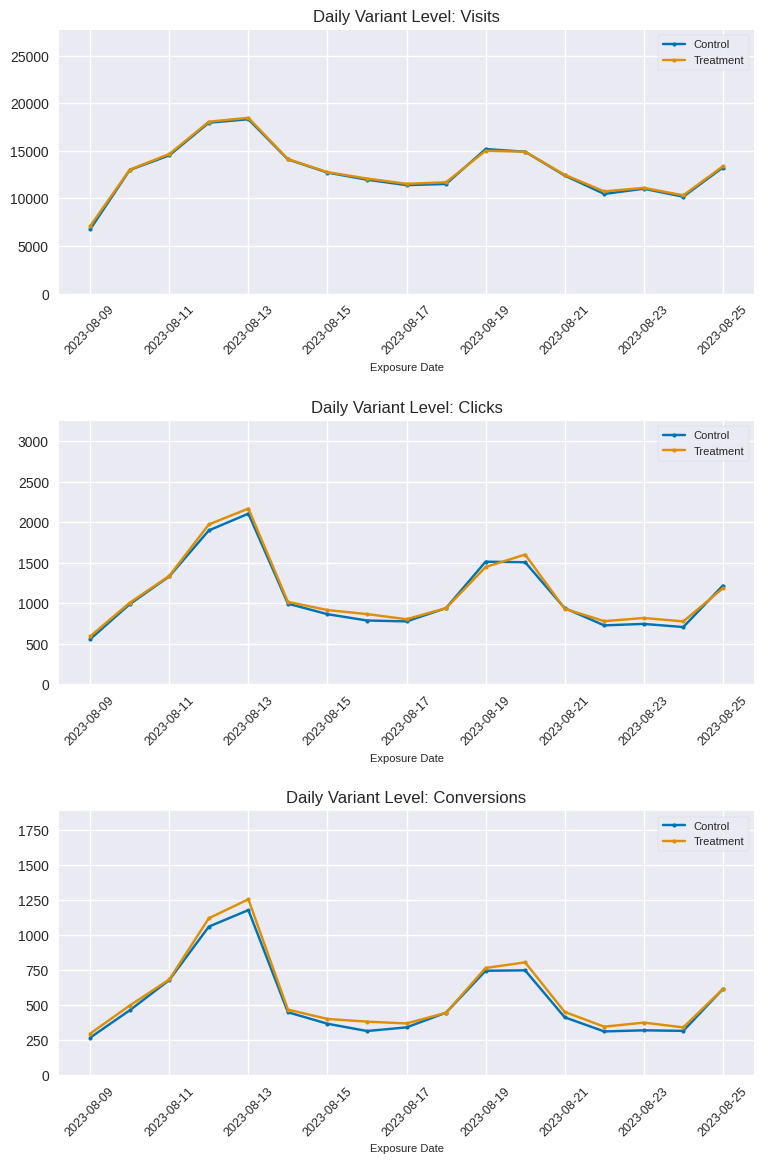

Funnel Metrics: Daily Variant Level.png
1 ['Monthly Conversions', 'Annual Conversions', 'Premium Conversions', 'Premium Plus Conversions'] Subscription Metrics
Subscription Metrics: Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

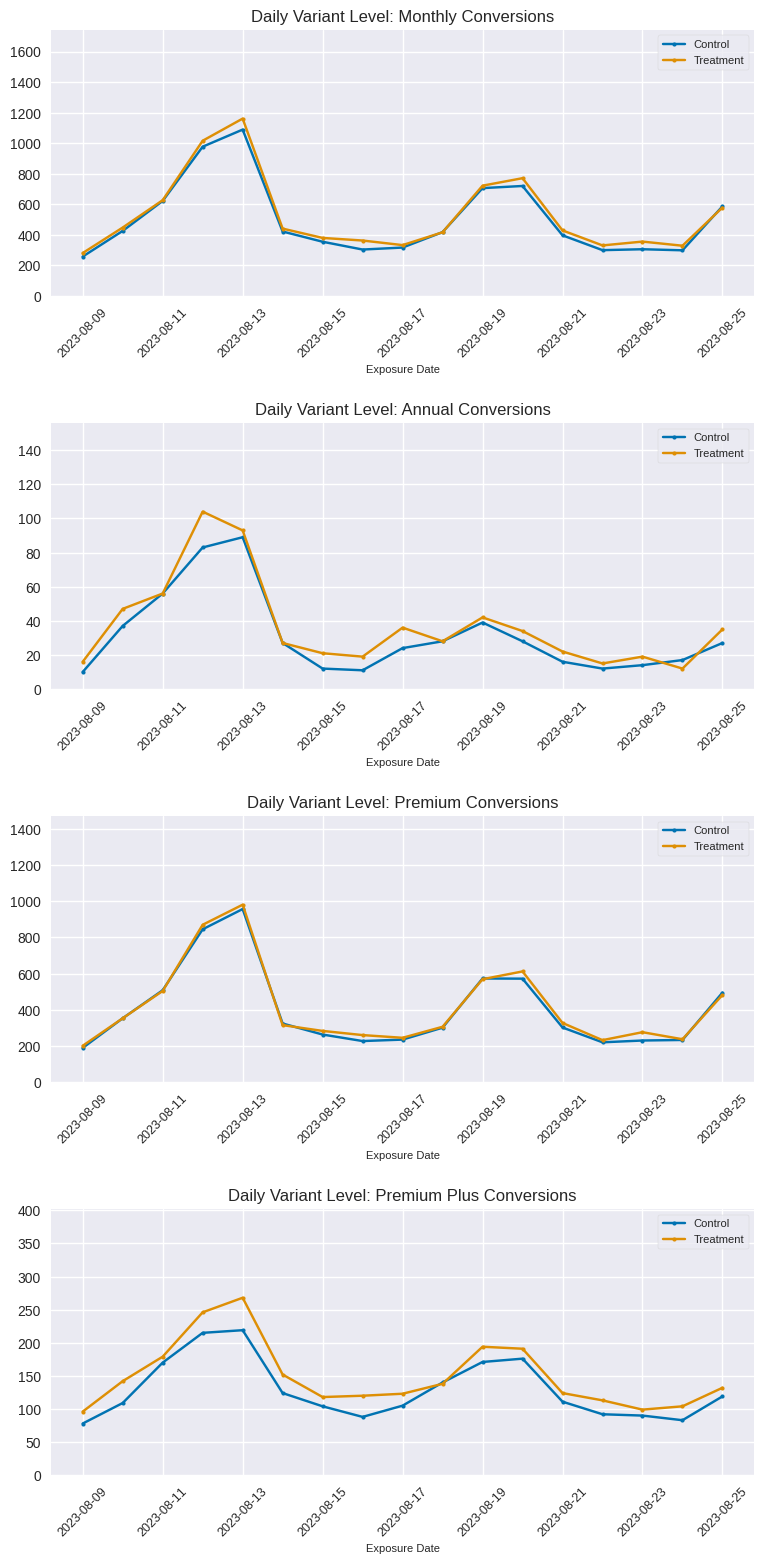

Subscription Metrics: Daily Variant Level.png
2 ['Click Rate', 'Conversion Rate'] Funnel Rates
Funnel Rates: Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

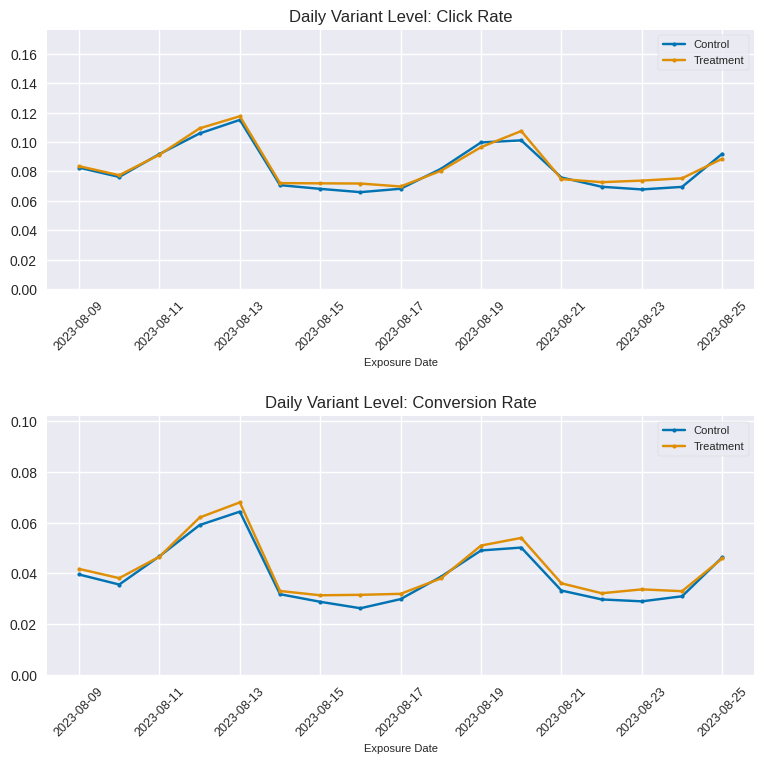

Funnel Rates: Daily Variant Level.png
3 ['Monthly Conversion Rate', 'Annual Conversion Rate', 'Premium Conversion Rate', 'Premium Plus Conversion Rate'] Subscription Rates
Subscription Rates: Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

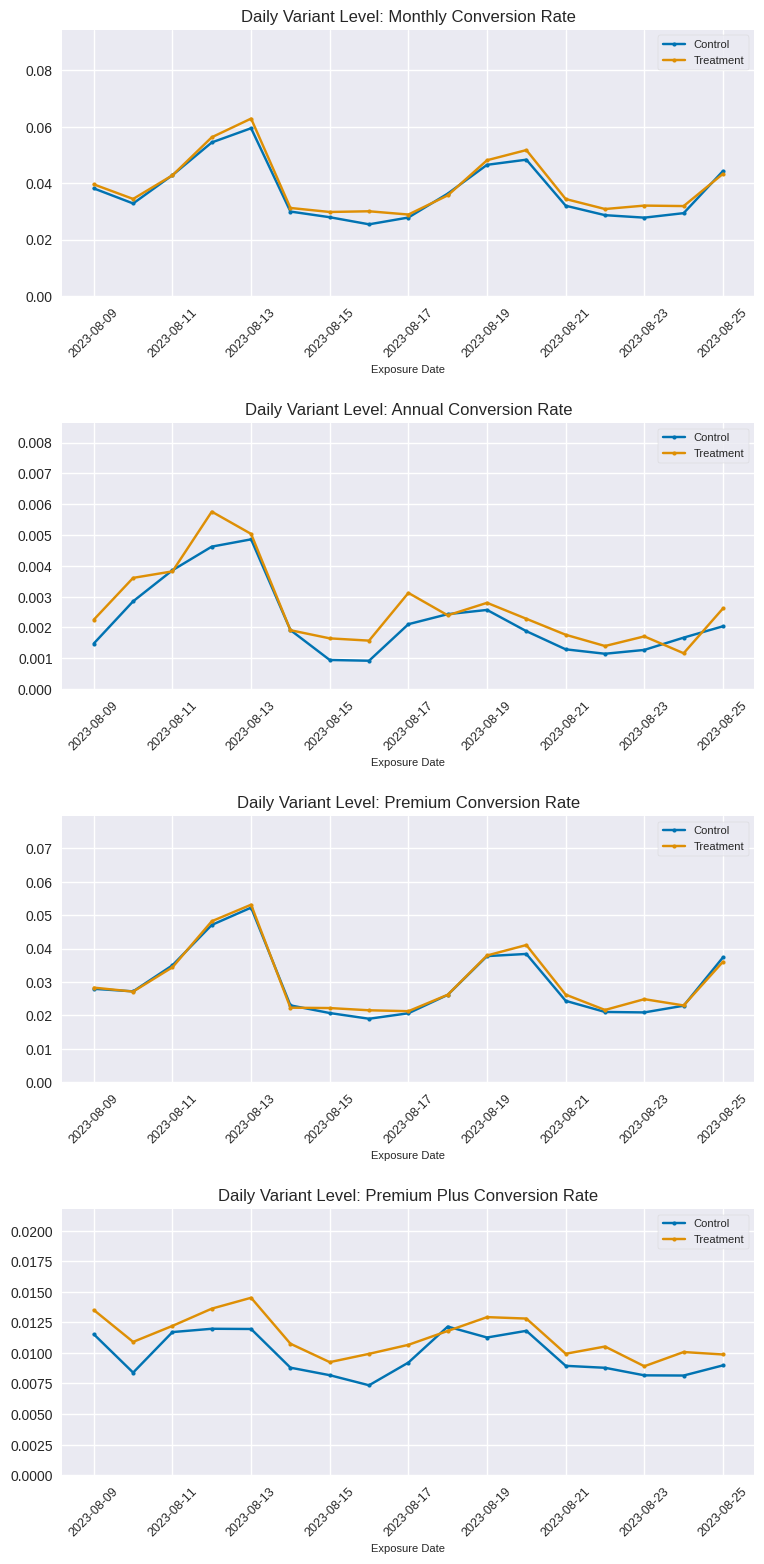

Subscription Rates: Daily Variant Level.png
4 ['Click Rate Relative Lift vs Control', 'Conversion Rate Relative Lift vs Control'] Funnel Rates vs Control
Funnel Rates vs Control: Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

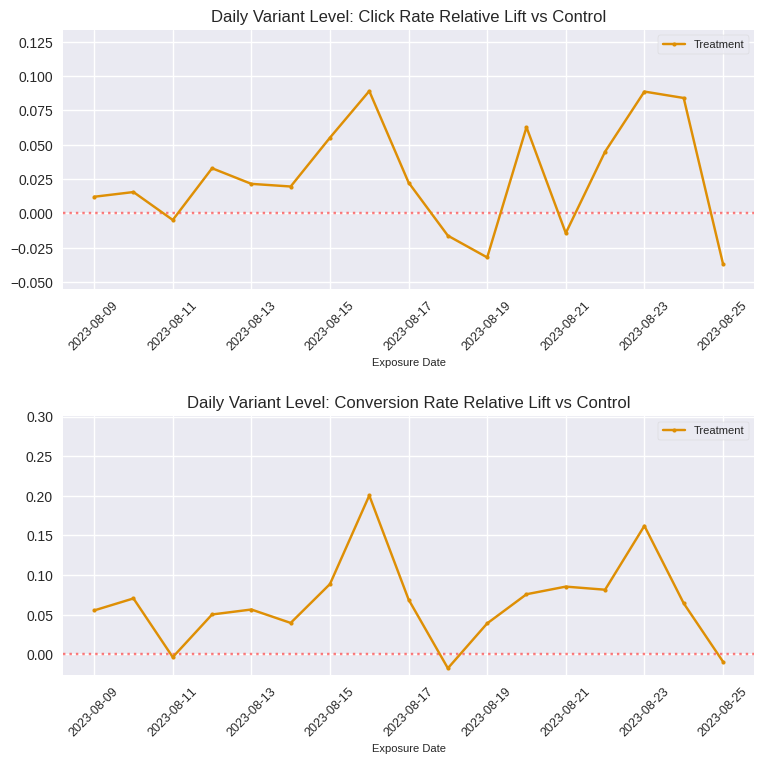

Funnel Rates vs Control: Daily Variant Level.png
5 ['Monthly Conversion Rate Relative Lift vs Control', 'Annual Conversion Rate Relative Lift vs Control', 'Premium Conversion Rate Relative Lift vs Control', 'Premium Plus Conversion Rate Relative Lift vs Control'] Subscription Rates vs Control
Subscription Rates vs Control: Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

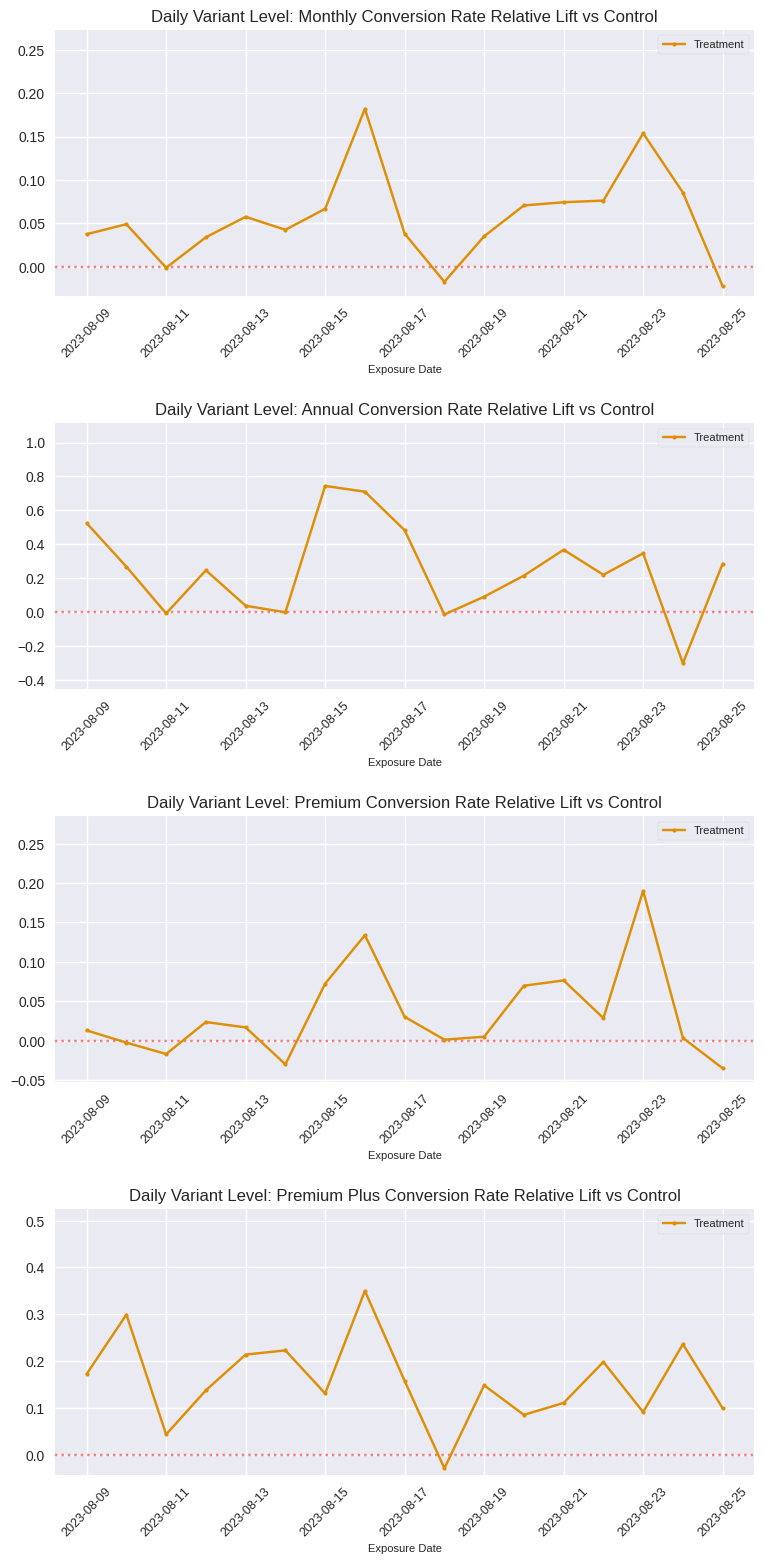

Subscription Rates vs Control: Daily Variant Level.png
0 ['Visits', 'Clicks', 'Conversions'] Funnel Metrics
Funnel Metrics: Cumulative Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

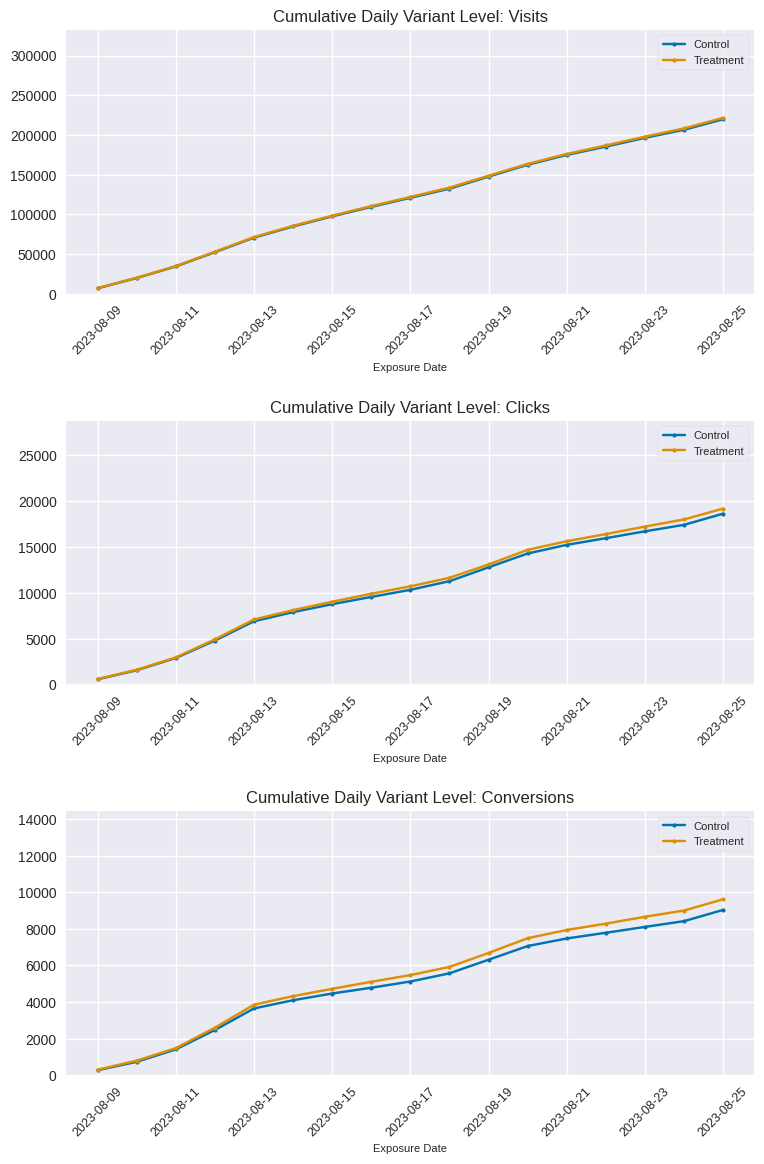

Funnel Metrics: Cumulative Daily Variant Level.png
1 ['Monthly Conversions', 'Annual Conversions', 'Premium Conversions', 'Premium Plus Conversions'] Subscription Metrics
Subscription Metrics: Cumulative Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

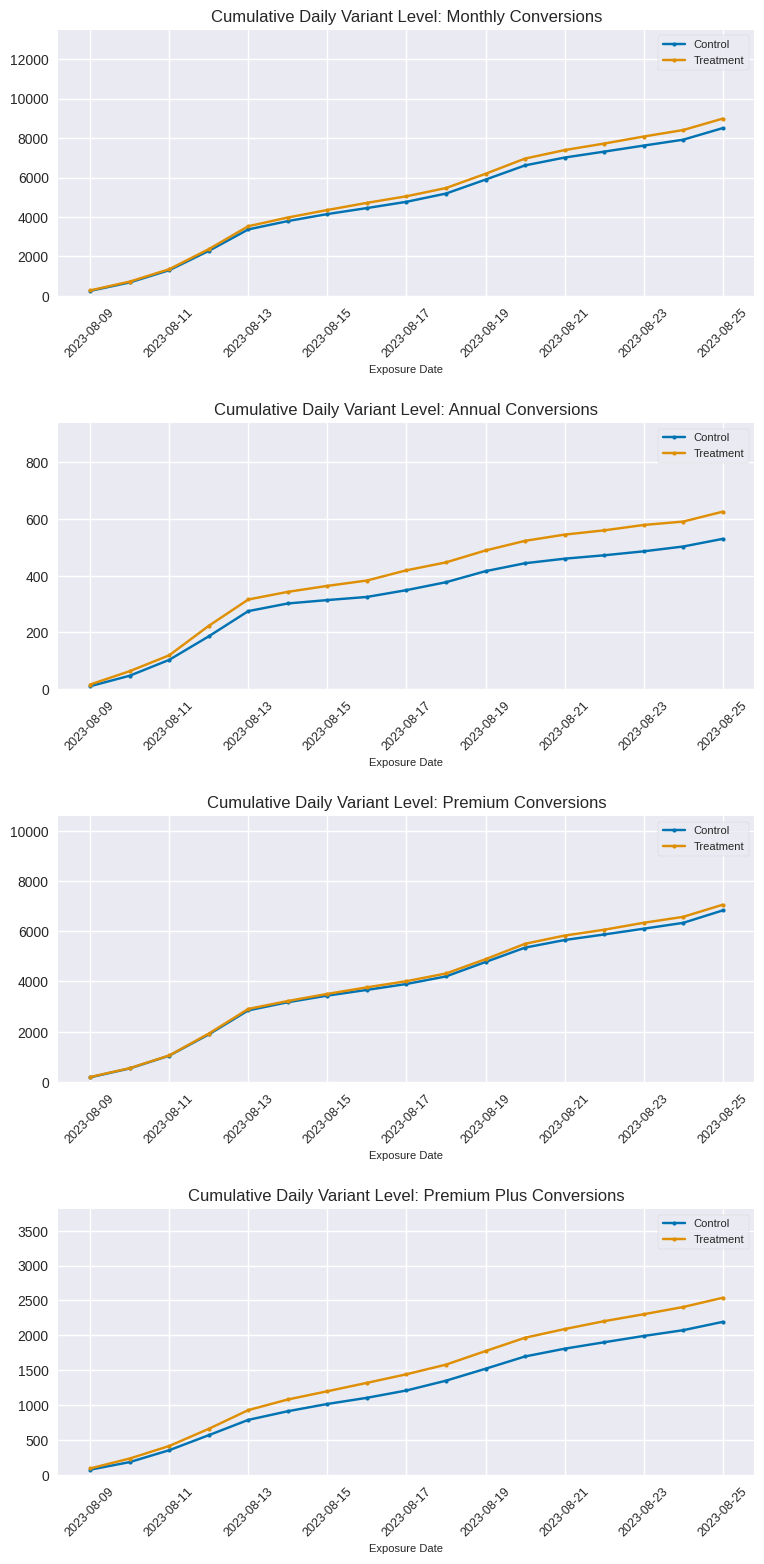

Subscription Metrics: Cumulative Daily Variant Level.png
2 ['Click Rate', 'Conversion Rate'] Funnel Rates
Funnel Rates: Cumulative Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

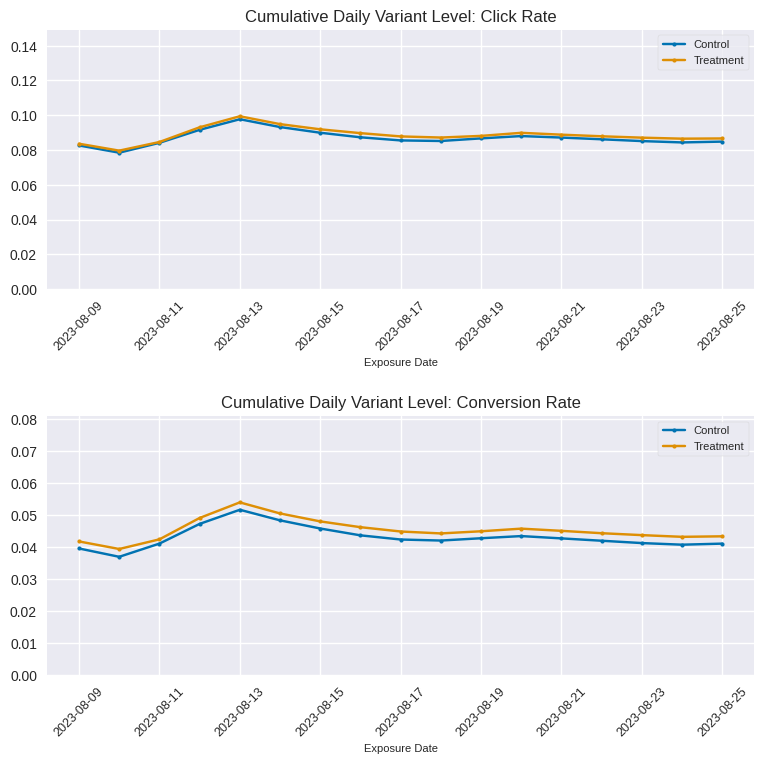

Funnel Rates: Cumulative Daily Variant Level.png
3 ['Monthly Conversion Rate', 'Annual Conversion Rate', 'Premium Conversion Rate', 'Premium Plus Conversion Rate'] Subscription Rates
Subscription Rates: Cumulative Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

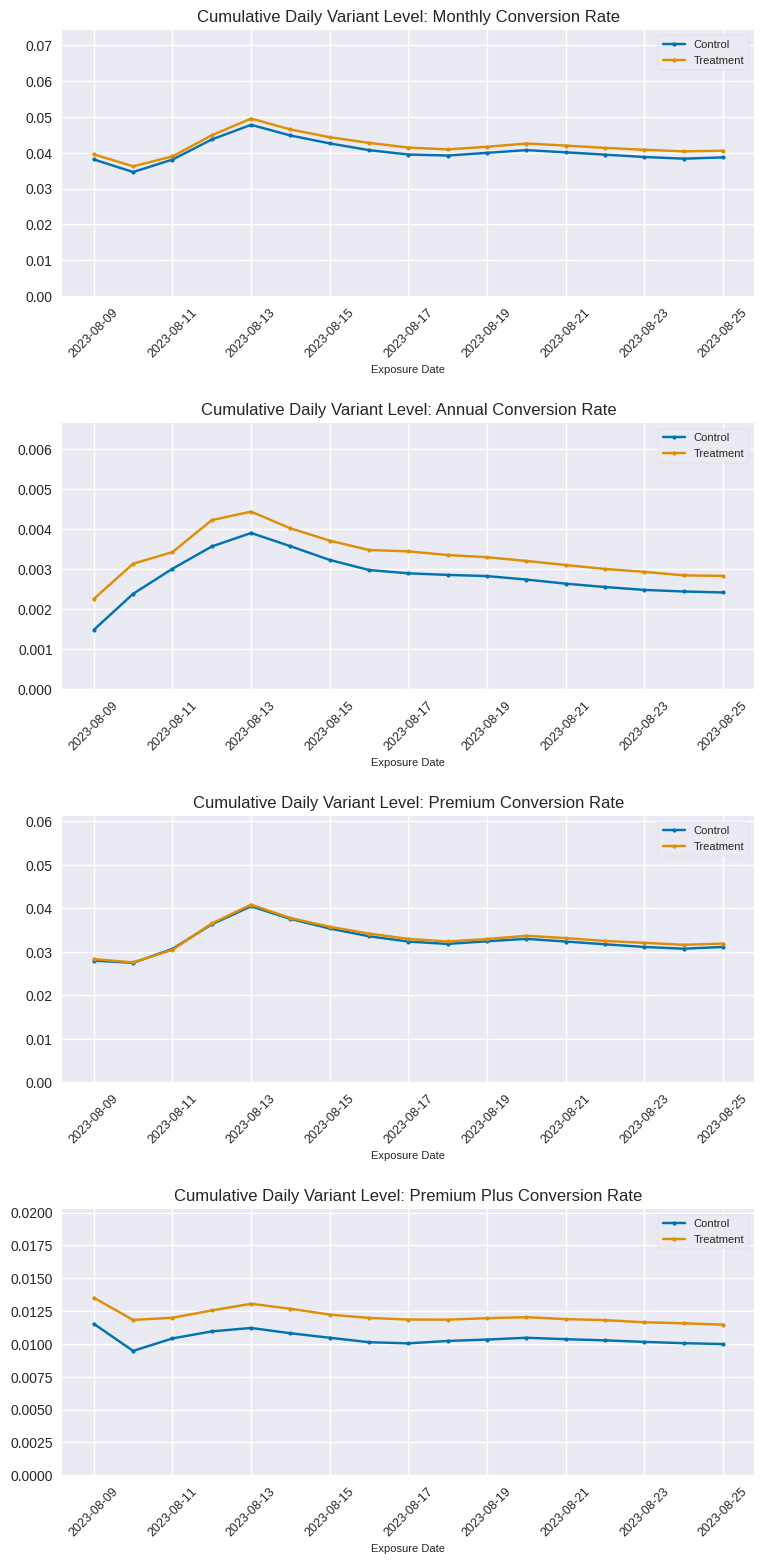

Subscription Rates: Cumulative Daily Variant Level.png
4 ['Click Rate Relative Lift vs Control', 'Conversion Rate Relative Lift vs Control'] Funnel Rates vs Control
Funnel Rates vs Control: Cumulative Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

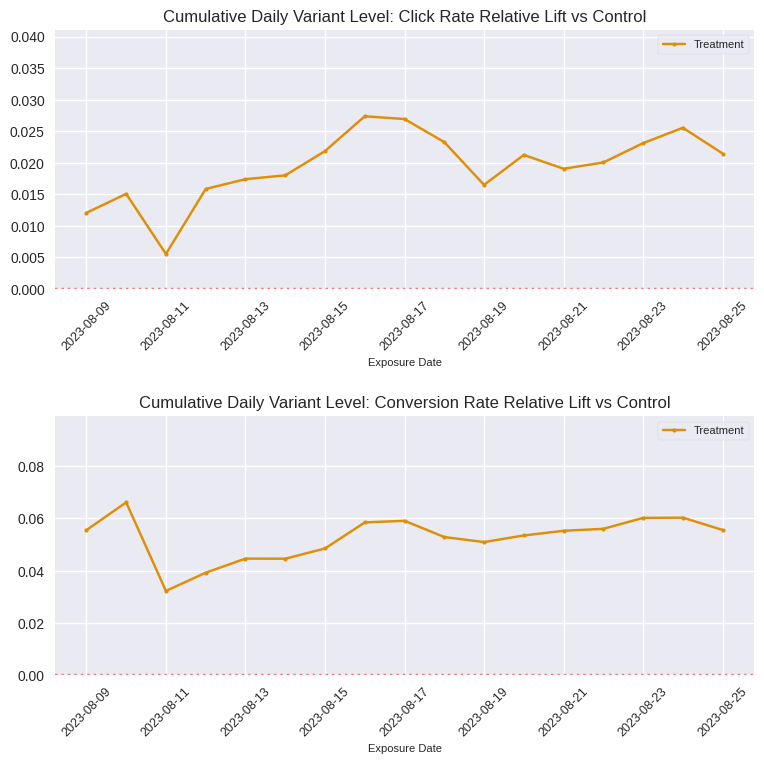

Funnel Rates vs Control: Cumulative Daily Variant Level.png
5 ['Monthly Conversion Rate Relative Lift vs Control', 'Annual Conversion Rate Relative Lift vs Control', 'Premium Conversion Rate Relative Lift vs Control', 'Premium Plus Conversion Rate Relative Lift vs Control'] Subscription Rates vs Control
Subscription Rates vs Control: Cumulative Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

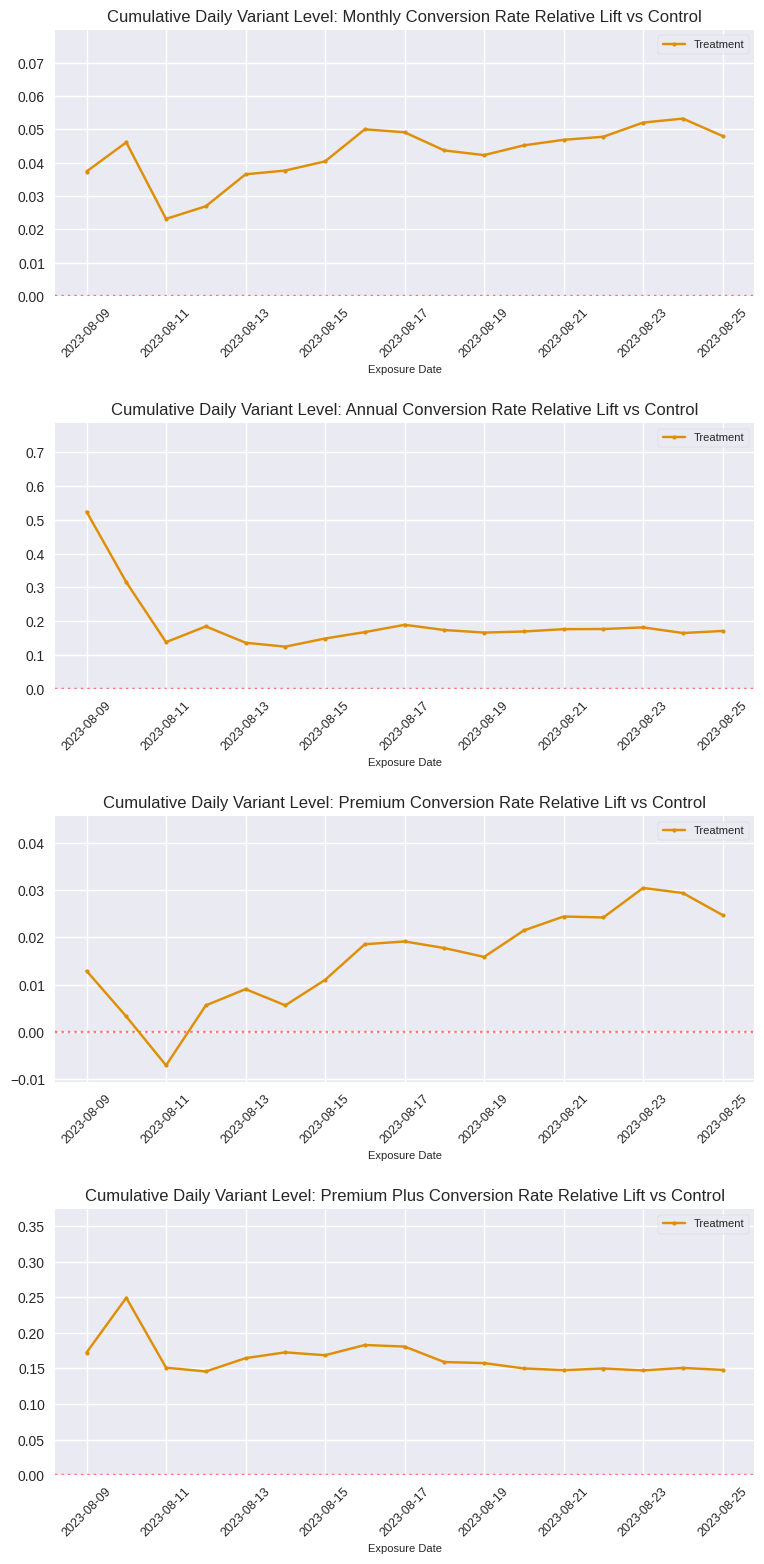

Subscription Rates vs Control: Cumulative Daily Variant Level.png


<Figure size 800x550 with 0 Axes>

In [393]:
# @title Visualize Time Series Data
def visualize_experiment_data(data_dict):
  for k, v in data_dict.items():
      # print(v.columns)
      # print(v['key'].unique())
      # print(v['find_key'].unique())
    if k.find('Daily Variant Level') >= 0:
      # Define metric groups based on user inputs
      metric_list_ov = url_metric_name_list.copy()
      try:
        metric_list_ov.remove("None") #remove Nones
      except ValueError:
        pass

      #get copy to edit
      metric_list_ov_fun = metric_list_ov.copy()
      #drop denominator column based on user inputs
      metric_list_ov_fun.remove(denom_name)

      """ NOTE: The following hard-coded lines"""
      metric_list_sub = ['Monthly Conversions', 'Annual Conversions', 'Premium Conversions', 'Premium Plus Conversions']
      #drop s and match metric naming conventions
      metric_list_ov_fun_new = [x[:-1] for x in metric_list_ov_fun if x.endswith('s')]
      metric_list_sub_new = [x[:-1] for x in metric_list_sub if x.endswith('s')]
      metric_list_ov_rate = [m + " Rate" for m in metric_list_ov_fun_new]
      metric_list_sub_rate = [m + " Rate" for m in metric_list_sub_new]
      metric_list_ov_vs_control = [m + " Relative Lift vs Control" for m in metric_list_ov_rate]
      metric_list_sub_vs_control = [m + " Relative Lift vs Control" for m in metric_list_sub_rate]

      metric_lol = [
            metric_list_ov, metric_list_sub,
            metric_list_ov_rate, metric_list_sub_rate,
            metric_list_ov_vs_control, metric_list_sub_vs_control
      ]
      metric_names_lol = ['Funnel Metrics','Subscription Metrics','Funnel Rates',
                          'Subscription Rates','Funnel Rates vs Control','Subscription Rates vs Control']
      """ End of hard-coding heavy section """
      for i, metric_group in enumerate(metric_lol):
        print(i, metric_group, metric_names_lol[i])
        chart_name = f"{metric_names_lol[i]}: {k}.png"
        print(chart_name)
        # Create a single set of subplots for each metric group
        fig, axes = plt.subplots(len(metric_group), 1, figsize=(8, len(metric_group)*4), sharey = False)
        plt.style.use('seaborn-v0_8-darkgrid')
        palette = sns.color_palette("colorblind")
        for a, metric in enumerate(metric_group):
          ax = axes[a]
          for i, variant_name in enumerate(v['variant_name'].unique()):
            sub_v = v[v['variant_name'] == variant_name]
            color = palette[i % len(palette)]
            if variant_name == control_name and metric.find('Relative Lift') > 0 :
              pass
            else: # if relative_lift_vs_control visualization and control variant, don't plot the data
              if metric.find('Relative Lift') > 0:
                ax.axhline(y=0.0, color='red', linestyle='dotted', alpha = .5)
              ax.plot(sub_v['exposure_date'], sub_v[metric], marker='o', markersize=3, linestyle='-', label=variant_name, color=color)
              # set up y-axis start point
              ylim_bot = min(sub_v[sub_v['variant_name'] == variant_name][metric].min() * 1.5, 0)
              ylim_top = max(sub_v[sub_v['variant_name'] == variant_name][metric].max() * 1.5, 0)
              ax.set_ylim(ylim_bot , ylim_top, auto = True)
          ax.set_xlabel('Exposure Date', fontsize = 8)
          ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize = 9)
          ax.set_title(f'{k}: {metric}')
          ax.legend(loc='best',  frameon=True, fontsize=8)
        plt.tight_layout(pad = 2)
        plt.show()
        print(chart_name)
        fig.savefig(parent_folder + '/' + tsv_name +'/'+  chart_name)
        plt.clf()
    else:
        pass

visualize_experiment_data(agg_lifts_dict)

In [389]:
# @title Conduct Hypothesis Testing
#return dictionary of tables with hypothesis testing results
def hypothesis_test(dict, alpha):
#new_dict to hold new dictionary of keys where values = dataframe with hypothesis test result s
  new_dict = {}
# iterate through dictionary
  for k,v in dict.items():
    # ADD KEYS TO dataframes
    join_keys_list = v.select_dtypes(include='object').columns.tolist()
    print("join_keys", join_keys_list)
    # Join the selected columns across rows and store the result in a new column
    v['key'] = v[join_keys_list].apply(lambda x: '-'.join(x), axis=1)
    #grab non variant_name cols to create a key to grab corresponding control
    find_keys_list = (join_keys_list.copy())
    find_keys_list.remove('variant_name')

    if len(find_keys_list) == 0: #set a key if none
      v['find_key'] = 'join'
    else: #create a concatenated column of non-numerics with variant_name col removed
      v['find_key'] = v[find_keys_list].apply(lambda x: '-'.join(x), axis=1)

    print("find_keys", find_keys_list)
    #determine if dataframe is eligible for hypothesis testing
    if k.find('Overall') == 0: #conduct hypothesis testing on "overall_" level data
      print("Starting hypothesis testing for: ",k)
      #create parsing key to get each unique grain-variant

      #split into control vs variants
      control_df = v[v['variant_name'] == control_name]
      variants_df = v[v['variant_name'] != control_name]

      print(control_df.head())

      # list of metrics to hypothesis test, int64 parses to non-normalized count metrics
      metric_list = v.select_dtypes(include='int64').columns.tolist()
      metric_list.remove(denom_name)
      print("metric_list to conduct hyp tests on ", metric_list)

      # instantiate a dataframe to store hypothesis test results
      hyp_df = pd.DataFrame(columns = ['variant_group', 'metric', 'sample_n', 'control_n', 'sample_mean', 'control_mean', 'absolute_diff', 'relative_diff', \
                                       'standard_error', 'p_value', 'alpha','ci_lower_absolute', 'ci_upper_absolute','ci_lower_relative', 'ci_upper_relative'])

      for vk in variants_df.key.unique(): #iterate through each unique subsetted variant, depends on key uniqueness to work correctly!
        vdf = variants_df[variants_df['key'] == vk] #subset variants_df
        fk = vdf['find_key'].iloc[0] # get find key of variant
        cdf = control_df[control_df['find_key'] == fk] # grab correct control row
        print("cdf: ", cdf.head(10))
        for m in metric_list: #iterate through each metric
          # get control and variant counts of metric
          c_count = cdf[m].iloc[0]
          v_count = vdf[m].iloc[0]

          # get control and variant denominator
          c_nob = cdf[denom_name].iloc[0]
          v_nob = vdf[denom_name].iloc[0]

          prop_c = c_count/c_nob
          prop_v = v_count/v_nob
          var = prop_c * (1 - prop_c)/c_nob + prop_v * (1 - prop_v)/v_nob
          se = np.sqrt(var)

          z_crit = stats.norm().ppf(1 - alpha/2)

          # put into 2x2 array
          counts = np.array([v_count, c_count])
          nobs = np.array([v_nob, c_nob])
          stat, pval = prop.proportions_ztest(counts, nobs)
          sample_mean = prop_v
          control_mean = prop_c
          sample_diff_abs = prop_v - prop_c
          sample_diff_relative = prop_v/prop_c - 1
          ci_lower_abs = sample_diff_abs - z_crit * se
          ci_upper_abs = sample_diff_abs + z_crit * se
          ci_lower_rel = ci_lower_abs/control_mean
          ci_upper_rel = ci_upper_abs/control_mean

          hyp_test_row = [vk, m, v_nob, c_nob, sample_mean, control_mean, sample_diff_abs, sample_diff_relative, \
                          se, pval, alpha, ci_lower_abs, ci_upper_abs, ci_lower_rel, ci_upper_rel]
          hyp_df.loc[len(hyp_df)] = hyp_test_row

      #drop s, add _rate to metric names to communicate we conducted proportions test
      hyp_df['metric'] = [x[:-1] for x in hyp_df['metric'] if x.endswith('s')]
      hyp_df['metric'] = hyp_df['metric'] + ' Rate'
      updates = {k: hyp_df}
      display(k, hyp_df)
      new_dict.update(updates)
    else: # dataframe not eligible for hyp testing
      pass
  return(new_dict)

hypothesis_dict = hypothesis_test(agg_lifts_dict, significance_level)

join_keys ['variant_name', 'user_status']
find_keys ['user_status']
join_keys ['variant_name']
find_keys []
join_keys ['variant_name', 'user_status']
find_keys ['user_status']
join_keys ['variant_name']
find_keys []
join_keys ['variant_name', 'user_status']
find_keys ['user_status']
Starting hypothesis testing for:  Overall Variant-User Status Level
  variant_name      user_status  Visits  Clicks  Conversions  \
0      Control         existing   72512    6654         4196   
1      Control  new acquisition  147215   11981         4838   

   Monthly Conversions  Annual Conversions  Premium Conversions  \
0                 3924                 272                 3236   
1                 4579                 258                 3591   

   Premium Plus Conversions  Premium Monthly Conversions  ...  \
0                       957                         3026  ...   
1                      1237                         3423  ...   

   Monthly Conversion Rate Relative Lift vs Control  \
0 

'Overall Variant-User Status Level'

,variant_group,metric,sample_n,control_n,sample_mean,control_mean,absolute_diff,relative_diff,standard_error,p_value,alpha,ci_lower_absolute,ci_upper_absolute,ci_lower_relative,ci_upper_relative
0,Treatment-existing,Click Rate,72921,72512,0.097571,0.091764,0.005807,0.063284,0.001535,0.000155,0.1,0.003282,0.008332,0.035766,0.090803
1,Treatment-existing,Conversion Rate,72921,72512,0.060915,0.057866,0.003049,0.052690,0.001239,0.013908,0.1,0.001010,0.005088,0.017457,0.087922
2,Treatment-existing,Monthly Conversion Rate,72921,72512,0.056637,0.054115,0.002521,0.046594,0.001199,0.035547,0.1,0.000549,0.004494,0.010137,0.083051
3,Treatment-existing,Annual Conversion Rate,72921,72512,0.004279,0.003751,0.000527,0.140625,0.000332,0.111733,0.1,-0.000018,0.001073,-0.004782,0.286032
4,Treatment-existing,Premium Conversion Rate,72921,72512,0.046228,0.044627,0.001601,0.035875,0.001092,0.142661,0.1,-0.000195,0.003397,-0.004376,0.076127
5,Treatment-existing,Premium Plus Conversion Rate,72921,72512,0.014577,0.013198,0.001380,0.104533,0.000614,0.024592,0.1,0.000370,0.002389,0.028050,0.181016
6,Treatment-existing,Premium Monthly Conversion Rate,72921,72512,0.043101,0.041731,0.001370,0.032839,0.001057,0.194787,0.1,-0.000368,0.003109,-0.008820,0.074498
7,Treatment-existing,Premium Monthly Plus Conversion Rate,72921,72512,0.013425,0.012343,0.001083,0.087720,0.000591,0.067174,0.1,0.000110,0.002055,0.008907,0.166532
8,Treatment-existing,Premium Annual Conversion Rate,72921,72512,0.003127,0.002896,0.000231,0.079625,0.000287,0.422305,0.1,-0.000242,0.000703,-0.083576,0.242825
9,Treatment-existing,Premium Plus Annual Conversion Rate,72921,72512,0.001152,0.000855,0.000297,0.347240,0.000166,0.073831,0.1,0.000024,0.000570,0.027875,0.666605


join_keys ['variant_name']
find_keys []
Starting hypothesis testing for:  Overall Variant Level
  variant_name  Visits  Clicks  Conversions  Monthly Conversions  \
0      Control  219727   18635         9034                 8503   

   Annual Conversions  Premium Conversions  Premium Plus Conversions  \
0                 530                 6827                      2194   

   Premium Monthly Conversions  Premium Monthly Plus Conversions  ...  \
0                         6449                              2042  ...   

   Monthly Conversion Rate Relative Lift vs Control  \
0                                               0.0   

   Annual Conversion Rate Relative Lift vs Control  \
0                                              0.0   

   Premium Conversion Rate Relative Lift vs Control  \
0                                               0.0   

   Premium Plus Conversion Rate Relative Lift vs Control  \
0                                                0.0       

   Premium Monthly Conv

'Overall Variant Level'

,variant_group,metric,sample_n,control_n,sample_mean,control_mean,absolute_diff,relative_diff,standard_error,p_value,alpha,ci_lower_absolute,ci_upper_absolute,ci_lower_relative,ci_upper_relative
0,Treatment,Click Rate,221526,219727,0.086631,0.084810,0.001821,0.021473,0.000843,0.030732,0.1,0.000435,0.003208,0.005126,0.037820
1,Treatment,Conversion Rate,221526,219727,0.043399,0.041115,0.002284,0.055560,0.000606,0.000163,0.1,0.001288,0.003281,0.031329,0.079790
2,Treatment,Monthly Conversion Rate,221526,219727,0.040555,0.038698,0.001857,0.047988,0.000587,0.001569,0.1,0.000891,0.002823,0.023024,0.072952
3,Treatment,Annual Conversion Rate,221526,219727,0.002826,0.002412,0.000414,0.171540,0.000154,0.007178,0.1,0.000161,0.000667,0.066623,0.276457
4,Treatment,Premium Conversion Rate,221526,219727,0.031838,0.031070,0.000768,0.024714,0.000526,0.143978,0.1,-0.000097,0.001632,-0.003106,0.052534
5,Treatment,Premium Plus Conversion Rate,221526,219727,0.011461,0.009985,0.001476,0.147849,0.000310,0.000002,0.1,0.000966,0.001986,0.096773,0.198925
6,Treatment,Premium Monthly Conversion Rate,221526,219727,0.029960,0.029350,0.000610,0.020794,0.000511,0.232120,0.1,-0.000230,0.001450,-0.007829,0.049417
7,Treatment,Premium Monthly Plus Conversion Rate,221526,219727,0.010513,0.009293,0.001220,0.131286,0.000298,0.000043,0.1,0.000730,0.001710,0.078525,0.184047
8,Treatment,Premium Annual Conversion Rate,221526,219727,0.001878,0.001720,0.000158,0.091592,0.000128,0.216902,0.1,-0.000052,0.000367,-0.030393,0.213577
9,Treatment,Premium Plus Annual Conversion Rate,221526,219727,0.000948,0.000692,0.000256,0.370359,0.000086,0.002958,0.1,0.000115,0.000398,0.165522,0.575196


Visualizing Overall Variant-User Status Level
0                      Click Rate
1                 Conversion Rate
2         Monthly Conversion Rate
3          Annual Conversion Rate
4         Premium Conversion Rate
5    Premium Plus Conversion Rate
Name: metric, dtype: object


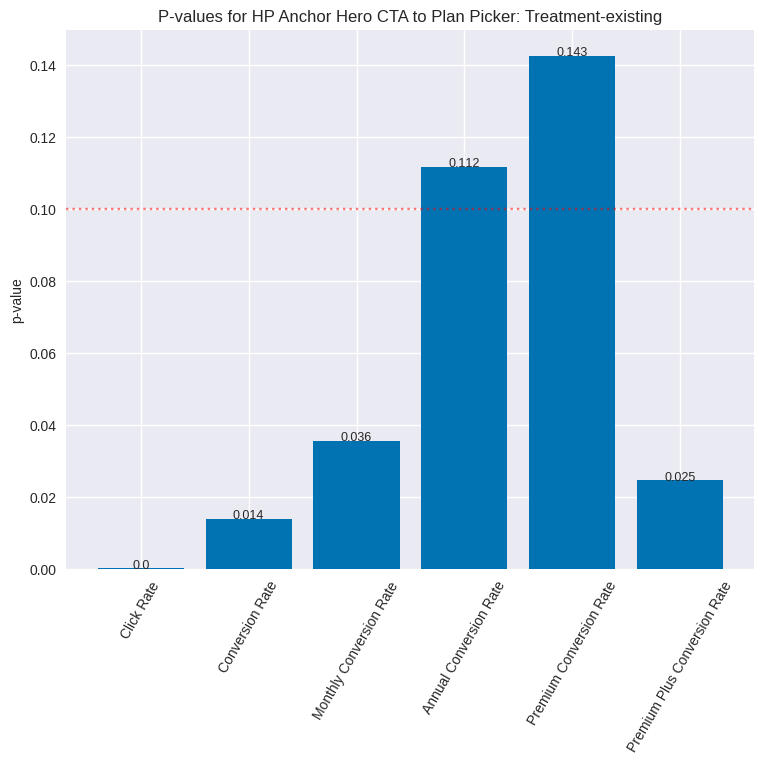

<Figure size 800x550 with 0 Axes>

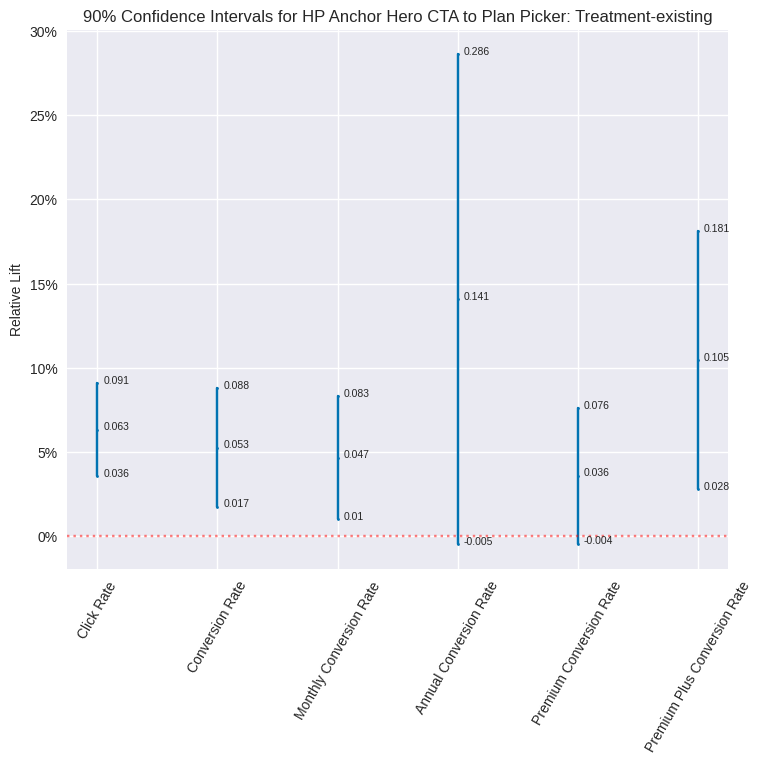

10                      Click Rate
11                 Conversion Rate
12         Monthly Conversion Rate
13          Annual Conversion Rate
14         Premium Conversion Rate
15    Premium Plus Conversion Rate
Name: metric, dtype: object


<Figure size 800x550 with 0 Axes>

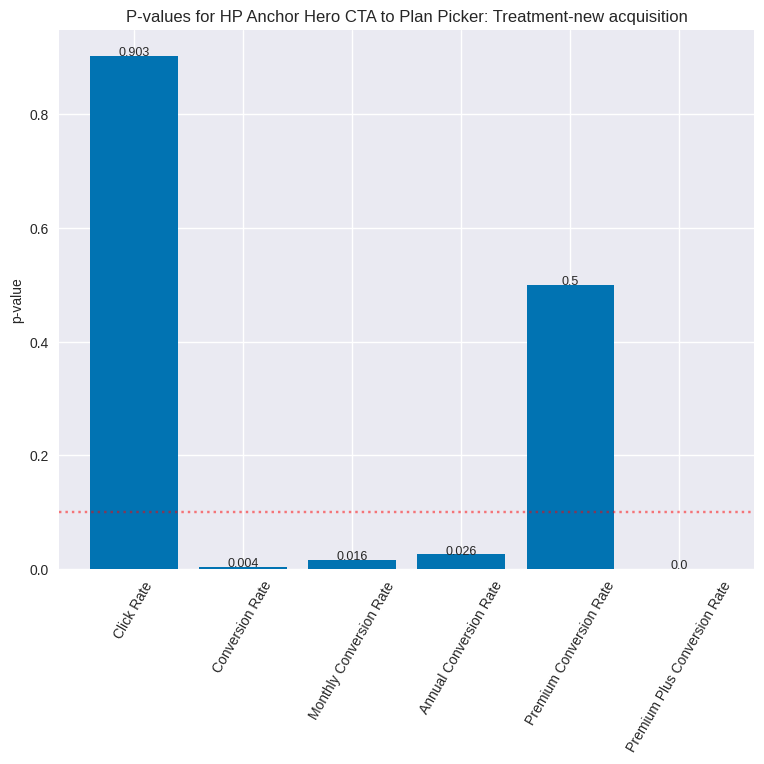

<Figure size 800x550 with 0 Axes>

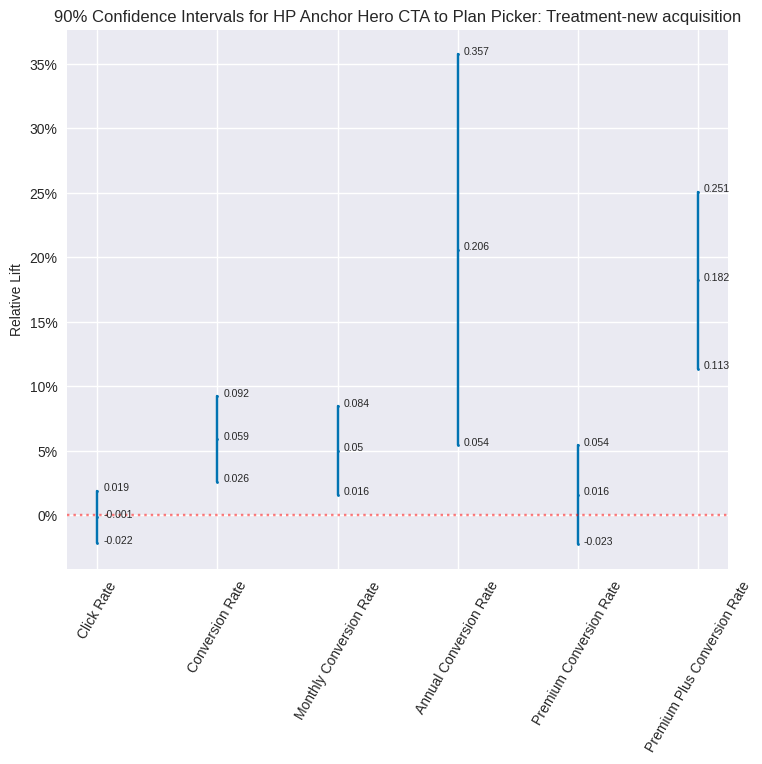

Visualizing Overall Variant Level
0                      Click Rate
1                 Conversion Rate
2         Monthly Conversion Rate
3          Annual Conversion Rate
4         Premium Conversion Rate
5    Premium Plus Conversion Rate
Name: metric, dtype: object


<Figure size 800x550 with 0 Axes>

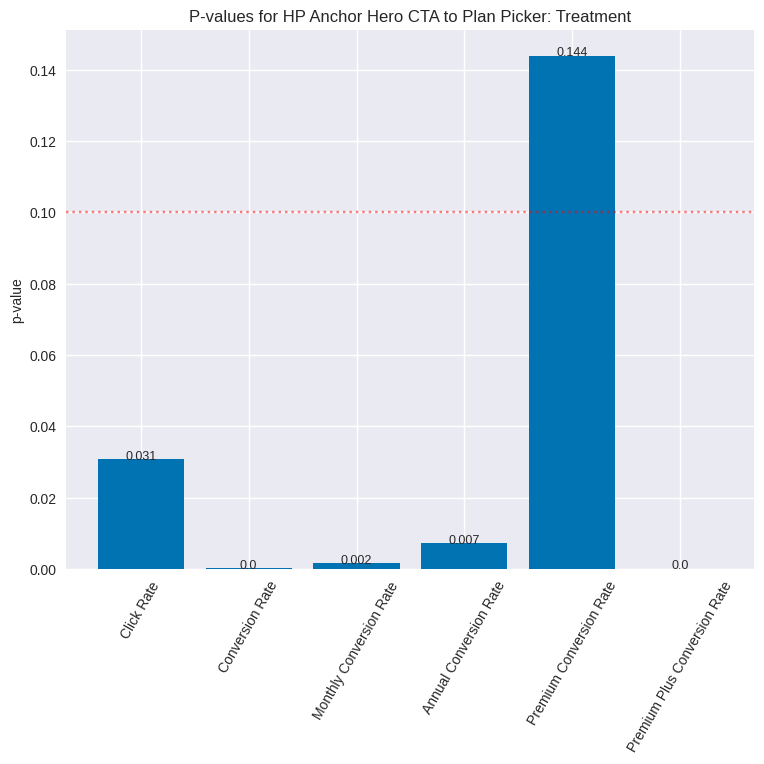

<Figure size 800x550 with 0 Axes>

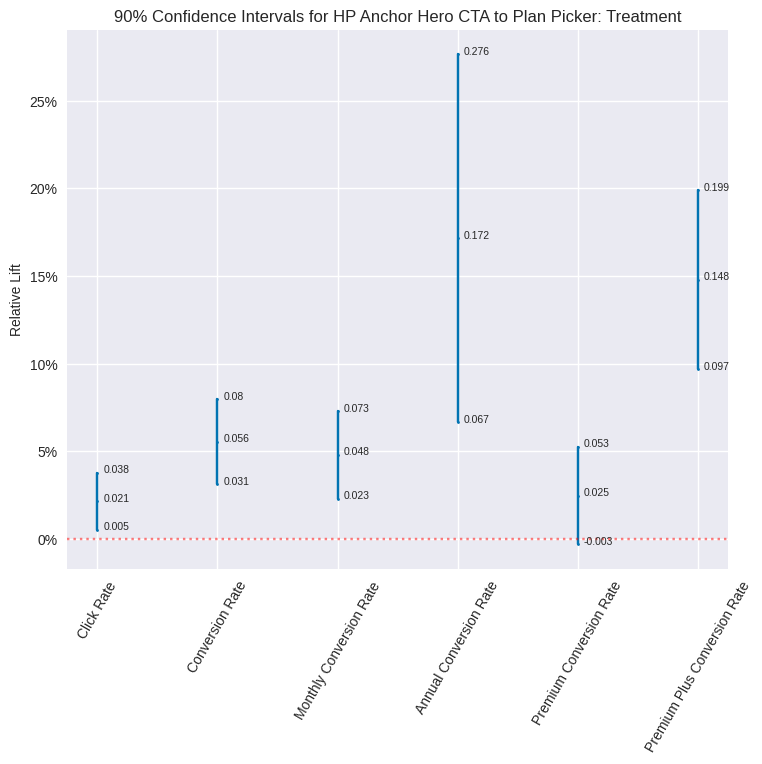

In [390]:
# @title Visualize Hypothesis Testing Data
def visualize_hyp_data(dict):
  """
  cycle through dictionary of hyp data frames
  plot p-values for each metric with significance line
  plot relative lift confidence intervals for each metric
  Note: each metric in hyp dict is expressed as a rate (normalized by visitors)
  """
  for k,v in dict.items():
    print("Visualizing", k)
    group_list = v['variant_group'].unique().tolist()
    #set up subplots
    plt.style.use('seaborn-muted')
    palette = sns.color_palette("colorblind")
    for id, g in enumerate(group_list):
      plt.figure(figsize = (8,8))
      #subset data frame to just 1 group
      var_v = v[v['variant_group'] == g]
      metrics_list = ['Click Rate', 'Conversion Rate', 'Monthly Conversion Rate', 'Annual Conversion Rate',
                      'Premium Conversion Rate', 'Premium Plus Conversion Rate']
      sub_v = var_v[var_v['metric'].isin(metrics_list)]
      #plot, name and save p-values
      plt.bar(sub_v['metric'], sub_v['p_value'], color = palette[0])
      print(sub_v['metric'])
      #plot data labels
      for i, val in enumerate(sub_v['p_value']):
        plt.text(i, val, round(val,3), ha = 'center', fontsize = 9)
      plt.xticks(fontsize=10, rotation=60)
      plt.yticks(fontsize=10)
      plt.ylabel("p-value", size=10)
      plt.title("P-values for "+ experiment_name + ': ' + g, size=12)
      plt.axhline(y=0.1, color='red', linestyle='dotted', label='Threshold (0.1)', alpha = .5)  # Add the dotted line
      plt.tight_layout(pad = 2)
      plt.savefig(f"{parent_folder}/{htv_name}/{k}; {g}: P-values.png")
      plt.show()
      plt.clf()

      #plot name and save confidence interval
      plt.figure(figsize = (8,8))
      plt.style.use('seaborn-muted')

      def percentage_formatter(x, pos):
        return f'{x * 100:.0f}%'
      for x, lower,relative, upper in zip(range(len(sub_v)), sub_v['ci_lower_relative'],sub_v['relative_diff'], sub_v['ci_upper_relative']):
        plt.plot((x,x,x),(lower,relative,upper), 'o-', color = palette[0] ,markersize = 2)
        plt.text(x+.05, lower, round(lower,3), ha = 'left', fontsize = 7.5)
        plt.text(x+.05, relative, round(relative,3), ha = 'left', fontsize = 7.5)
        plt.text(x+.05, upper, round(upper,3), ha = 'left', fontsize = 7.5)
        plt.xticks(range(len(sub_v)),list(sub_v['metric']), rotation = 60, fontsize=10)


        plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
        plt.ylabel("Relative Lift", size=10)
        plt.title(str(percentage_formatter(1- significance_level,0))+ " Confidence Intervals for "+ experiment_name + ': ' + g, size=12)
      plt.axhline(y=0.0, color='red', linestyle='dotted', alpha = .5)
      plt.tight_layout(pad = 2)
      plt.savefig(f"{parent_folder}/{htv_name}/{k}: {g}: Relative Lift CI.png")
      plt.show()
      plt.clf()
  plt.close()
  pass
#run function
visualize_hyp_data(hypothesis_dict)

In [391]:
# @title Log Data into Excel Sheets
def log_data(dict, name, parent_folder, subfolder_name):
  """ Take in a dictionary of dataframes and import into xlsx spreadsheet
  Log down all data used for visualizations and hypothesis testing
  """
  # Specify the Excel file name
  excel_file = parent_folder+ '/' + subfolder_name + '/'+ name + '.xlsx'

  # Create a Pandas Excel writer using ExcelWriter
  with pd.ExcelWriter(excel_file) as writer:
      # Iterate through the dictionary and write each DataFrame to a sheet
      for sheet_name, df in dict.items():
          df.to_excel(writer, sheet_name=sheet_name, index=False)

log_data(agg_lifts_dict, 'Analysis Data', parent_folder, al_name )
log_data(hypothesis_dict, 'Hypothesis Testing Data', parent_folder, al_name)